> ### Loading required packages

>> When using transfer learning models one need to have access to their data/model. When using one's one local computer the data/model will automatically be loaded via the internet. Since a Kaggle kernel does not have access to the interent we need to get the pretrained model/data for the kernel by doing the following:
 * First we add the Keras Pretrained Models data by clicking on the kernel's Data tab, doing a search for it, and adding it.
 * Once we have the data we need to create the directories for our kernel (which follows).

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from os import makedirs
from os.path import join, exists, expanduser
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Create the directories for the pretrained models
#!ls ../input/keras-pretrained-models/   # just to be sure the data is here

cache_dir = expanduser(join('~', '.keras'))
if not exists(cache_dir):
    makedirs(cache_dir)
models_dir = join(cache_dir, 'models')
if not exists(models_dir):
    makedirs(models_dir)
    
!ls ~/.keras/models  
!cp ../input/keras-pretrained-models/*notop* ~/.keras/models/
!cp ../input/keras-pretrained-models/imagenet_class_index.json ~/.keras/models/
!cp ../input/keras-pretrained-models/resnet50* ~/.keras/models/

> ## Loading the NIH Chest X-ray Dataset

> ## **Data Exploration**

>> NIH Chest X-ray Dataset contains 112,120 total .png images with size 1024 x 1024 and disease names labels from 30,805 unique patients which are acquired by reducing radiological reports using NLP text mining methods into a few pathology keywords or “No finding” otherwise. Entity extraction is not perfect and expected to be >90% accurate. Authors are trying to maximize the recall of finding accurate disease by eliminating all possible negations and uncertainties. For instance, terms like: ‘It is hard to exclude …’ are treated as uncertainty cases and then the image will be labeled as “No finding” which could be treated as normal or contain disease patterns other than the listed 14.

In [3]:
data_path = '../input/data/'
all_xray_df = pd.read_csv(os.path.join(data_path,'Data_Entry_2017.csv'))

image_paths = glob(os.path.join(data_path,'images_???','images','*.png'))

all_image_paths = { os.path.basename(x): x for x in image_paths }

print('Scans found     : ', len(all_image_paths), 'images')
print('Total Headers   : ', all_xray_df.shape[0], 'headers')
print('Unique Patients : ',len(np.unique(all_xray_df['Patient ID'])), ' patients')

all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)

print('\nColumns/Features in the dataset are as follows :\n')
print(all_xray_df.columns)
all_xray_df

Scans found     :  112120 images
Total Headers   :  112120 headers
Unique Patients :  30805  patients

Columns/Features in the dataset are as follows :

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11', 'path'],
      dtype='object')


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,../input/data/images_001/images/00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,../input/data/images_001/images/00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,../input/data/images_001/images/00000001_002.png
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,../input/data/images_001/images/00000002_000.png
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,../input/data/images_001/images/00000003_000.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168,NaN,../input/data/images_012/images/00030801_001.png
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168,NaN,../input/data/images_012/images/00030802_000.png
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,NaN,../input/data/images_012/images/00030803_000.png
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168,NaN,../input/data/images_012/images/00030804_000.png


> ## Preliminary Analysis of the Dataset

>> ### Distribution of 'Finding Labels' 

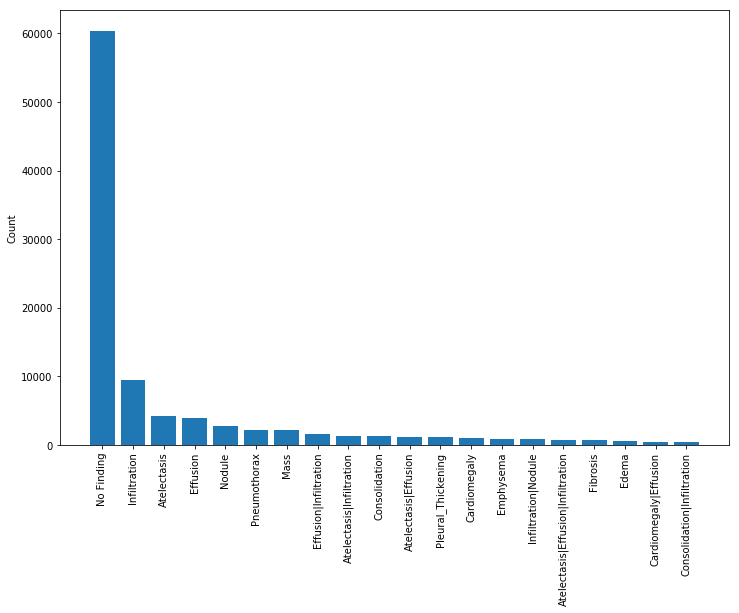

In [4]:
#Here we take the labels and make them into a more clear format. 
#The primary step is to see the distribution of findings and then to convert them to simple binary labels.
label_counts = all_xray_df['Finding Labels'].value_counts()[0:20] # Top 20 combination of Finding Labels
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)
_ = ax1.set_ylabel('Count')
fig.savefig('findings_distribution.png')

>> ### Distribution of 'Patient Age'

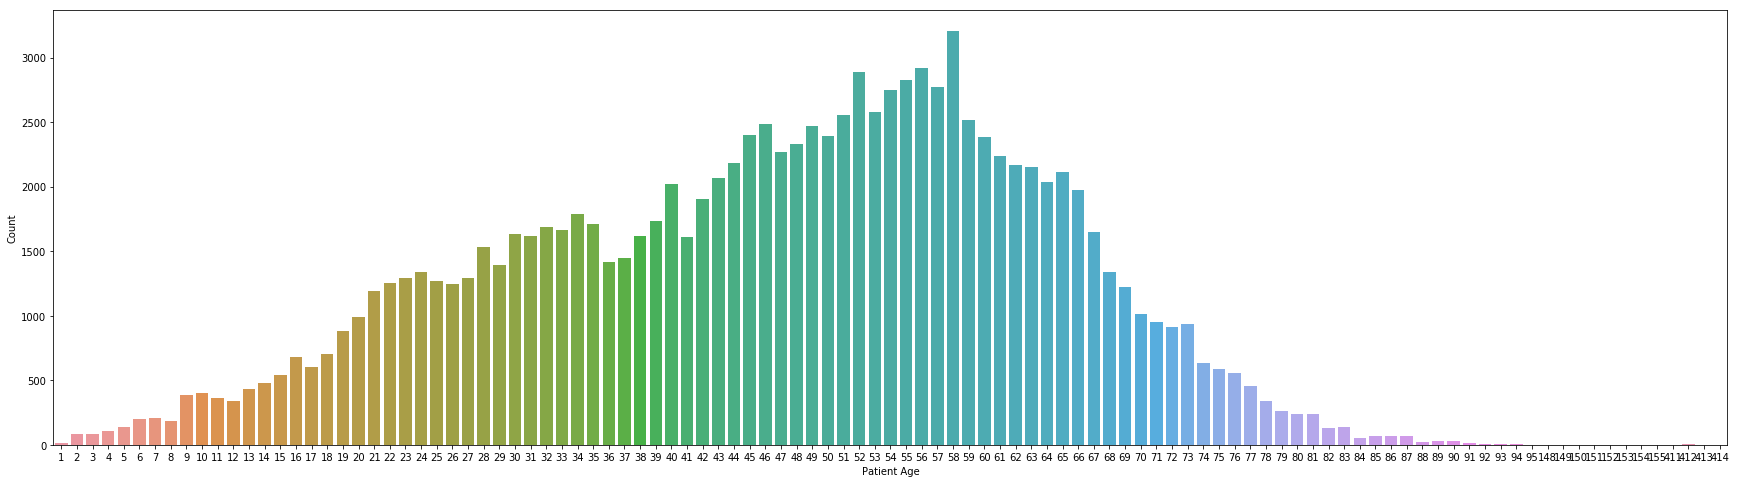

In [5]:
ax = plt.figure(figsize=(30, 8))
sns.countplot(all_xray_df['Patient Age'])
plt.xlabel('Patient Age')
plt.ylabel('Count')
plt.savefig('age_distribution.png')

>>> #### Analysis reveals that there are some data instances (16 in total) where age>100 which might be potential outliers. So, they are dropped from the dataset.

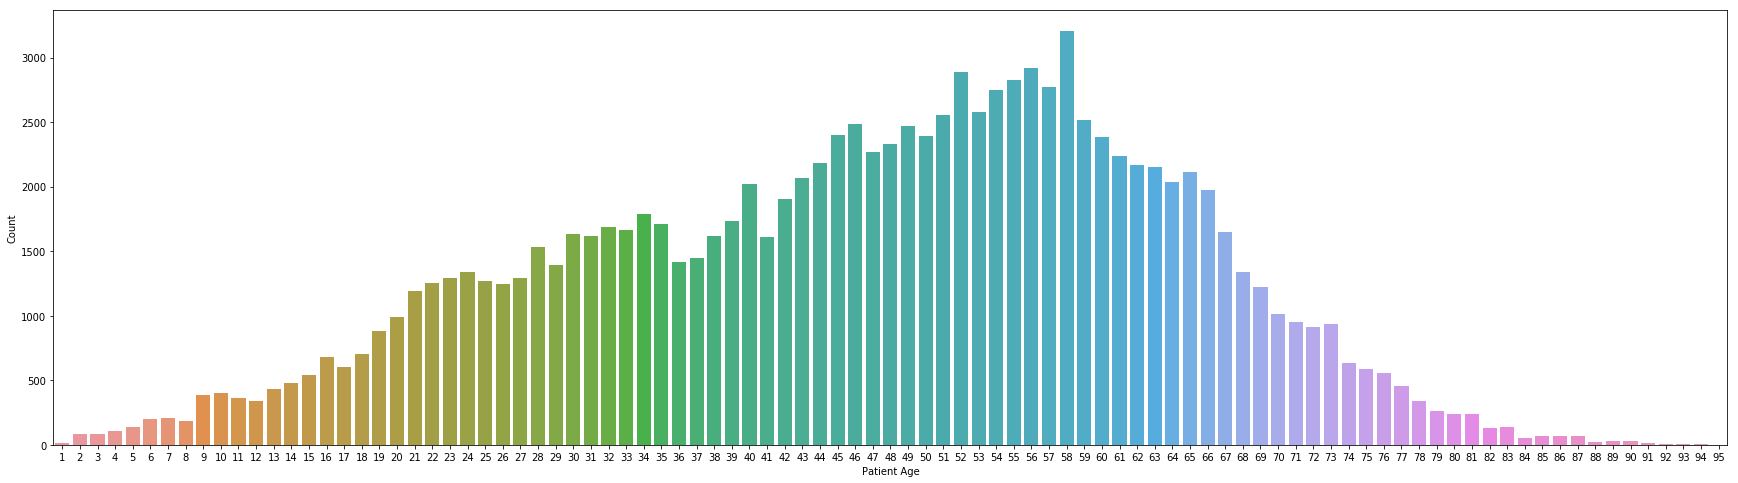

In [6]:
indeces=[]
for index in range(len(all_xray_df)):
    if all_xray_df['Patient Age'][index]>100:
        indeces.append(index)
all_xray_df = all_xray_df.drop(indeces,axis=0)
ax = plt.figure(figsize=(30, 8))
sns.countplot(all_xray_df['Patient Age'])
plt.xlabel('Patient Age')
plt.ylabel('Count')
plt.savefig('age_distribution_new.png')

> ### Modelling or Generating our target Labels i.e. the Pathologies and augmenting it to the dataset

>> #### Formally, the task is as follows. All images are associated with a ground truth labels i.e. 'Finding Labels' and we want to find such a classification function that minimizes a loss function using training labels. We encode the labels for each image as binary over all the possible labels.

>> #### Particularly, we encode “No Findings” as a separate class as it signifies that either the image doesn't belong to any of the given labels or has no disease.

In [7]:
from itertools import chain
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_xray_df['Finding Labels List'] = all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist()
print('All Pathologies/Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1 if c_label in finding else 0)
all_xray_df

All Pathologies/Labels (15): ['Atelectasis' 'Cardiomegaly' 'Consolidation' 'Edema' 'Effusion'
 'Emphysema' 'Fibrosis' 'Hernia' 'Infiltration' 'Mass' 'No Finding'
 'Nodule' 'Pleural_Thickening' 'Pneumonia' 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,0,1,0,0,0,0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,...,0,0,0,0,1,0,0,0,1,0
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,...,0,0,0,0,0,1,0,0,0,0
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,...,0,0,0,0,0,1,0,0,0,0
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,...,0,0,0,0,0,1,0,0,0,0


> ### Getting the count of each label/pathology in the original (complete) dataset

In [8]:
for c_label in all_labels:
    print((c_label,int(all_xray_df[c_label].sum())))

('Atelectasis', 11558)
('Cardiomegaly', 2776)
('Consolidation', 4667)
('Edema', 2302)
('Effusion', 13316)
('Emphysema', 2516)
('Fibrosis', 1686)
('Hernia', 227)
('Infiltration', 19891)
('Mass', 5779)
('No Finding', 60353)
('Nodule', 6331)
('Pleural_Thickening', 3384)
('Pneumonia', 1430)
('Pneumothorax', 5301)


> ### Visualizing each pathologies frequency distribution

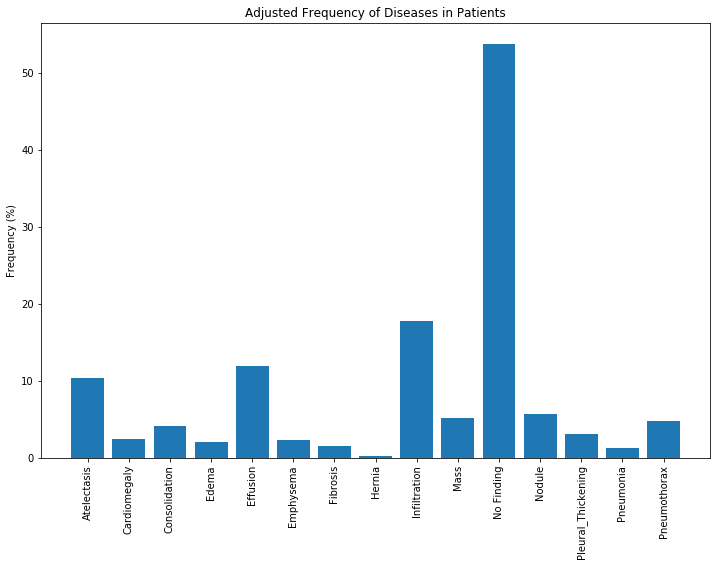

In [9]:
label_counts = 100*np.mean(all_xray_df[all_labels].values,0)
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
ax1.set_xticklabels(all_labels, rotation = 90)
ax1.set_title('Adjusted Frequency of Diseases in Patients')
_ = ax1.set_ylabel('Frequency (%)')
fig.savefig('frequency_distribution.png')

> ### Removing/Dropping irrelevant columns/features from the dataset

In [10]:
#Removing irrelevant columns
all_xray_df.drop(['Image Index','Finding Labels','Follow-up #','OriginalImage[Width','Height]',
                  'OriginalImagePixelSpacing[x','y]','Unnamed: 11'],axis=1, inplace=True)
all_xray_df

,Patient ID,Patient Age,Patient Gender,View Position,path,Finding Labels List,Atelectasis,Cardiomegaly,Consolidation,Edema,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,1,58,M,PA,../input/data/images_001/images/00000001_000.png,[Cardiomegaly],0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,58,M,PA,../input/data/images_001/images/00000001_001.png,"[Cardiomegaly, Emphysema]",0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
2,1,58,M,PA,../input/data/images_001/images/00000001_002.png,"[Cardiomegaly, Effusion]",0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,81,M,PA,../input/data/images_001/images/00000002_000.png,[No Finding],0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,3,81,F,PA,../input/data/images_001/images/00000003_000.png,[Hernia],0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,30801,39,M,PA,../input/data/images_012/images/00030801_001.png,"[Mass, Pneumonia]",0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
112116,30802,29,M,PA,../input/data/images_012/images/00030802_000.png,[No Finding],0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
112117,30803,42,F,PA,../input/data/images_012/images/00030803_000.png,[No Finding],0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
112118,30804,30,F,PA,../input/data/images_012/images/00030804_000.png,[No Finding],0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


> ### Encoding Features within the Dataset
*  Patient Gender is encoded into binary {M,F} -> {0,1}
*  View Position is encoded into binary as well {AP,PA} -> {0,1}

In [11]:
all_xray_df['Patient Gender']=all_xray_df['Patient Gender'].map(lambda gender: 0 if gender=='M' else 1)
all_xray_df['View Position']=all_xray_df['View Position'].map(lambda vp: 0 if vp=='AP' else 1)
all_xray_df

,Patient ID,Patient Age,Patient Gender,View Position,path,Finding Labels List,Atelectasis,Cardiomegaly,Consolidation,Edema,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,1,58,0,1,../input/data/images_001/images/00000001_000.png,[Cardiomegaly],0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,58,0,1,../input/data/images_001/images/00000001_001.png,"[Cardiomegaly, Emphysema]",0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
2,1,58,0,1,../input/data/images_001/images/00000001_002.png,"[Cardiomegaly, Effusion]",0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,81,0,1,../input/data/images_001/images/00000002_000.png,[No Finding],0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,3,81,1,1,../input/data/images_001/images/00000003_000.png,[Hernia],0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,30801,39,0,1,../input/data/images_012/images/00030801_001.png,"[Mass, Pneumonia]",0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
112116,30802,29,0,1,../input/data/images_012/images/00030802_000.png,[No Finding],0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
112117,30803,42,1,1,../input/data/images_012/images/00030803_000.png,[No Finding],0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
112118,30804,30,1,1,../input/data/images_012/images/00030804_000.png,[No Finding],0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


> ### Creating training, validation and test dataframes by splitting the original dataset
* The split perecentage is as follows : 
 1. Training Set - 70%
 2. Validation Set - 10%
 3. Test Set - 20%
* Since a single patient has several 'Follow ups' i.e. there are number of records belonging to one patient, we make sure that all records belonging to one patient are there in either of the subset.

In [12]:
patients=np.unique(all_xray_df['Patient ID'])
from sklearn.model_selection import train_test_split
train_valid, test = train_test_split(patients, 
                                   test_size = 0.2, 
                                   random_state = 2020)
train, valid = train_test_split(train_valid,
                                test_size = 0.12,
                                random_state = 2020)
print('No. of Unique Patients in Train dataset : ',len(train))
print('No. of Unique Patients in Valid dataset : ',len(valid))
print('No. of Unique Patients in Test dataset  : ',len(test))

train_df = all_xray_df[all_xray_df['Patient ID'].isin(train)]
valid_df = all_xray_df[all_xray_df['Patient ID'].isin(valid)]
test_df = all_xray_df[all_xray_df['Patient ID'].isin(test)]
print('\nTraining Dataframe   : ', train_df.shape[0],' images')
print('Validation Dataframe : ', valid_df.shape[0],' images')
print('Testing Dataframe    : ', test_df.shape[0],' images')

No. of Unique Patients in Train dataset :  21684
No. of Unique Patients in Valid dataset :  2957
No. of Unique Patients in Test dataset  :  6161

Training Dataframe   :  78481  images
Validation Dataframe :  10836  images
Testing Dataframe    :  22787  images


In [13]:
print('Count of each label/pathology in the Train dataset')
for c_label in all_labels:
    print((c_label,int(train_df[c_label].sum())))

print('\nCount of each label/pathology in the Valid dataset')
for c_label in all_labels:
    print((c_label,int(valid_df[c_label].sum())))

print('\nCount of each label/pathology in the Test dataset')
for c_label in all_labels:
    print((c_label,int(test_df[c_label].sum())))

Count of each label/pathology in the Train dataset
('Atelectasis', 8080)
('Cardiomegaly', 1858)
('Consolidation', 3280)
('Edema', 1639)
('Effusion', 9258)
('Emphysema', 1800)
('Fibrosis', 1173)
('Hernia', 137)
('Infiltration', 13828)
('Mass', 3999)
('No Finding', 42319)
('Nodule', 4479)
('Pleural_Thickening', 2357)
('Pneumonia', 966)
('Pneumothorax', 3726)

Count of each label/pathology in the Valid dataset
('Atelectasis', 1100)
('Cardiomegaly', 322)
('Consolidation', 442)
('Edema', 238)
('Effusion', 1307)
('Emphysema', 206)
('Fibrosis', 159)
('Hernia', 32)
('Infiltration', 1971)
('Mass', 630)
('No Finding', 5834)
('Nodule', 565)
('Pleural_Thickening', 322)
('Pneumonia', 137)
('Pneumothorax', 485)

Count of each label/pathology in the Test dataset
('Atelectasis', 2378)
('Cardiomegaly', 596)
('Consolidation', 945)
('Edema', 425)
('Effusion', 2751)
('Emphysema', 510)
('Fibrosis', 354)
('Hernia', 58)
('Infiltration', 4092)
('Mass', 1150)
('No Finding', 12200)
('Nodule', 1287)
('Pleural_Th

> ### Normalizing 'Patient Age' within the Datasets
*  Patient Age in normalized in the range [min(Age),max(Age)] -> [0,1]
* Note : We dropped the 'Patient ID' coulmn from all the datasets

In [14]:
pd.options.mode.chained_assignment = None
min_age = min(train_df['Patient Age'])
diff = max(train_df['Patient Age']) - min_age
train_df['Patient Age'] = train_df['Patient Age'].map(lambda age: (age-min_age)/diff)
train_df.drop('Patient ID',axis=1,inplace=True)

min_age = min(valid_df['Patient Age'])
diff = max(valid_df['Patient Age']) - min_age
valid_df['Patient Age'] = valid_df['Patient Age'].map(lambda age: (age-min_age)/diff)
valid_df.drop('Patient ID',axis=1,inplace=True)

min_age = min(test_df['Patient Age'])
diff = max(test_df['Patient Age']) - min_age
test_df['Patient Age'] = test_df['Patient Age'].map(lambda age: (age-min_age)/diff)
test_df.drop('Patient ID',axis=1,inplace=True)

> ### Data Preparation

>> #### To form a usable data pipeline we construct Image Data Generator. It deals with several things:
*  Transforms our images to an appropriate shape for the model input size.
*  Avoids holding in memory all the dataset.
*  Data augmentation (extend the training data).

>>> The Generator augments our dataset by flipping, rotating, shifting, shearing and zooming images. Keras takes care of all that preprocessing.

 >>>> For example, 
*  *height_shift_range* and *width_shift_range* cut out small stripes from the images. 
* *rotation_range* controls the angle the picture may be rotated. 
* *shear_range* describes the angle on which the panoramic distortion will be done. 
* If after augmenting the borders appear to be empty *fill_mode = ‘reflect’* allows to fill those part with reflection of an image. 
* Parameters *samplewise_center=True*, *samplewise_std_normalization=True* allow to transform the image pixels to have a standard normal distribution. 

In [15]:
from keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
data_gen = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

Using TensorFlow backend.


In [16]:
# train_df.to_csv('train.csv')
# valid_df.to_csv('valid.csv')
# test_df.to_csv('test.csv')

In [17]:
# Creating DataFrame Iterators

print('Generating Training DataFrame Iterator')
train_gen = data_gen.flow_from_dataframe(dataframe=train_df, 
                                                directory=None,
                                                x_col = 'path',
                                                y_col = 'Finding Labels List', 
                                                target_size = IMG_SIZE,
                                                class_mode='categorical',
                                                color_mode = 'grayscale',
                                                batch_size = 64)

print('\nGenerating Validation DataFrame Iterator')
valid_gen = data_gen.flow_from_dataframe(dataframe=valid_df, 
                                                directory=None,
                                                x_col = 'path',
                                                y_col = 'Finding Labels List', 
                                                target_size = IMG_SIZE,
                                                color_mode = 'grayscale',
                                                class_mode='categorical',
                                                batch_size = 64) # We can use larger batches for evaluation

print('\nGenerating Test DataFrame Iterator')
test_gen = data_gen.flow_from_dataframe(dataframe=test_df, 
                                                directory=None,
                                                x_col = 'path',
                                                y_col ='Finding Labels List', 
                                                target_size = IMG_SIZE,
                                                color_mode = 'grayscale',
                                                class_mode='categorical',
                                                batch_size = 64) 

Generating Training DataFrame Iterator
Found 78481 validated image filenames belonging to 15 classes.

Generating Validation DataFrame Iterator
Found 10836 validated image filenames belonging to 15 classes.

Generating Test DataFrame Iterator
Found 22787 validated image filenames belonging to 15 classes.


> ### Plotting some of the Training samples of first batch for visualization

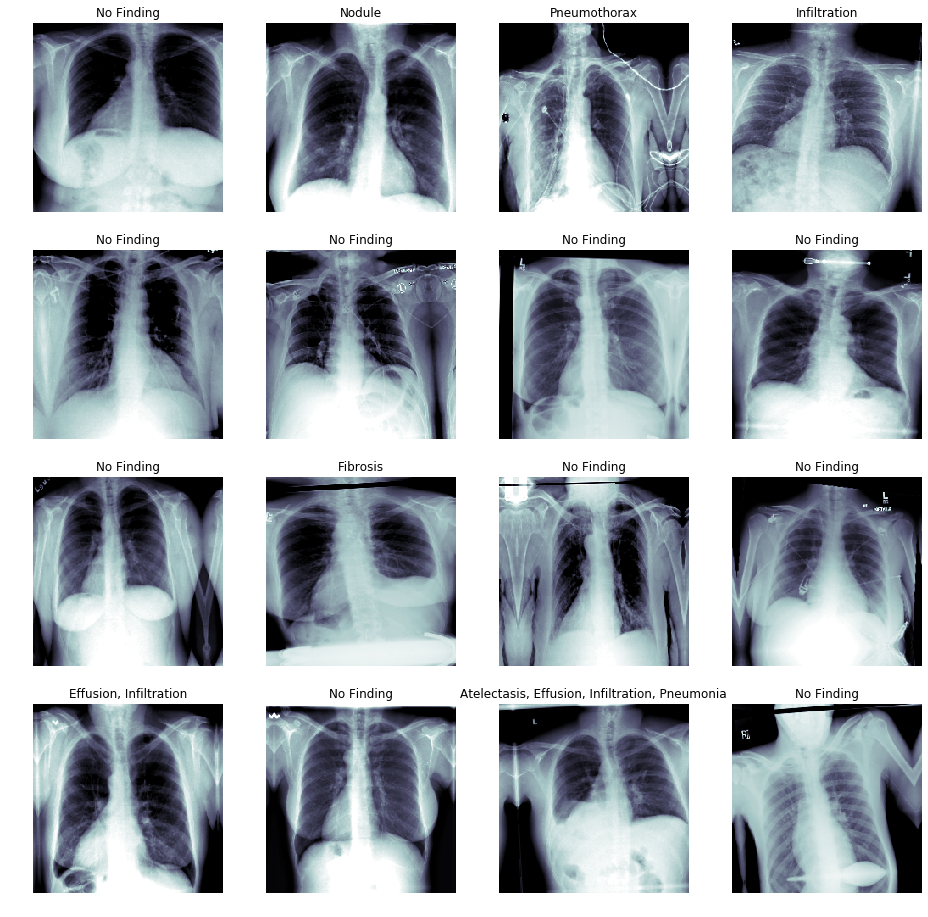

In [18]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(train_gen.class_indices.keys(), c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

fig.savefig('train_gen_samples.png')
train_gen.reset()

## Building the Model

> ### We are going to make use of ResNet-50 alongwith Transfer Learning to achieve our goal of predicting the patholgoies as accurately as possible. The model is pre-trained on *ImageNet Dataset*.

* We create a *Sequential Model* incorporating *Resnet-50 Model* for our task
* We store the best weights after every epoch by making use of *ModelCheckpoint*.
* We make use of *early stopping* i.e. inhibiting further training of our model by monitoring validation loss. If the validation loss doesn't improve continuously for a defined no. of epochs i.e. *patience* we stop our training.
* We also make use *reduce lr on plateau* i.e. reducing the learning rate when our model is stuck on a plateau.

In [19]:
#Create a simple Model
from keras.models import Sequential
# from keras.applications.resnet50 import ResNet50
# from keras.applications.densenet import DenseNet121
from keras.applications.vgg19 import VGG19
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=7, verbose=1, restore_best_weights=True)

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=2, mode='min')

callbacks_list = [checkpoint, early_stop, lr_reduce]


base_VGG19= VGG19(include_top = False, weights = 'imagenet')
#All the layers are trainable i.e. the model is fine-tuned.

model = Sequential()

80142336/80134624 [==============================] - 3s 0us/step


> ### Creating the model and getting its summary.
* We add an initial *Conv2D layer* that takes *1-channel (grayscale)* input image and outputs a *3-channel (rgb)* image.
* We add *Global Average Pooling Layer* on top of ResNet-50 model's output layer.
* Finally we add *Dense layer* to reduce the no. of outputs to required labels i.e. 15. The activation function used is *sigmoid*.

In [20]:
from keras.layers import GlobalAveragePooling2D, Dense, Conv2D

#Freezed conv layer which produces the same image with 3 channels
convol_same = Conv2D(trainable=False, input_shape=t_x.shape[1:], filters=3, kernel_size=(1, 1), strides=(1, 1), 
                     padding='valid', data_format=None, dilation_rate=(1, 1), activation=None, use_bias=True, 
                     kernel_initializer='ones', bias_initializer='zeros', kernel_regularizer=None, 
                     bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)

model.add(convol_same)
model.add(base_VGG19)
model.add(GlobalAveragePooling2D())
model.add(Dense(len(all_labels), activation = 'sigmoid'))
# model.load_weights('../input/learned-weights/weights_model_resnet50epochs.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 3)       6         
_________________________________________________________________
vgg19 (Model)                multiple                  20024384  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)                7695      
Total params: 20,032,085
Trainable params: 20,032,079
Non-trainable params: 6
_________________________________________________________________


> ### Compiling the Model
* Considering unbalanced class distribution we decided to use weighted *binary cross entropy* as the loss function while training. That literally means that we assign higher constant factor to the loss function for the instances which are weakly represented in the dataset.
* We use *Adam* as the optimizer with learning rate as 0.0001 with default parameters for beta1 = 0.9 and beta2 = 0.999.

In [21]:
#Compile the model
from keras import optimizers
adam = optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

> ### Writing the model to json.

In [22]:
with open('model_resnet.json', 'w') as f:
    f.write(model.to_json())

> ### Computing the Class Weights (since the data is unbalanced)

In [23]:
total = all_xray_df.shape[0]

class_weights = {}

for key in train_gen.class_indices.keys():
    amount = all_xray_df['Finding Labels List'].map(lambda x: key in x).sum()
    class_number = train_gen.class_indices[key]
    class_weights [class_number] = total/amount
    
class_weights
# those will be passed to balance the model treating of different classes

{0: 9.699255926630904,
 1: 40.38328530259366,
 2: 24.020569959288622,
 3: 48.69852302345786,
 4: 8.41874436767798,
 5: 44.55643879173291,
 6: 66.49110320284697,
 7: 493.85022026431716,
 8: 5.635915740787291,
 9: 19.39851185326181,
 10: 1.8574718738090898,
 11: 17.707155267730215,
 12: 33.12765957446808,
 13: 78.3944055944056,
 14: 21.147707979626485}

> ### Fitting our Input/Training Data and Training the Model

In [ ]:
history = model.fit_generator(train_gen, 
                              steps_per_epoch=train_gen.n//train_gen.batch_size,
                              validation_data = valid_gen, 
                              validation_steps = valid_gen.n//valid_gen.batch_size,
                              epochs = 10, 
                              class_weight = class_weights,
                              callbacks = callbacks_list)

model.save_weights('weights_model_vgg.h5')

Epoch 1/10
1130/1226 [==========================>...] - ETA: 2:14 - loss: 2.9755 - accuracy: 0.9158

In [ ]:
model.save('trained_vgg19.h5')

> ### Model reconstruction from JSON File

In [ ]:
# from keras.models import model_from_json

# with open('model_resnet.json', 'r') as f:
#     model = model_from_json(f.read())

# # Load the saved weights into the new model
# model.load_weights('weights_model_resnet.h5')

In [ ]:
from keras.models import load_model
model = load_model('trained_vgg19.h5')

> ### Predicting the labels/pathology of the test dataset.

In [ ]:
from tqdm import tqdm
test_gen.reset()
steps = len(test_gen.classes)//test_gen.batch_size

test_y_list = []
pred_y_list = []

for i in tqdm(range(steps)):
    test_X, test_Y = next(test_gen)
    pred_Y = model.predict(test_X)
    test_y_list.append(test_Y)
    pred_y_list.append(pred_Y)
    
test_y_all = np.concatenate(test_y_list)
pred_y_all = np.concatenate(pred_y_list)

> ### Evaluating the model on test dataset

In [ ]:
# model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
test_gen.reset()
steps = len(test_gen.classes)//test_gen.batch_size

test_acc_list = []
test_loss_list = []

for i in range(steps):
    print(i)
    test_X, test_Y = next(test_gen)
    test_loss,test_acc = model.evaluate(test_X,test_Y,test_gen.batch_size,verbose=0)
    test_acc_list.append(test_acc)
    test_loss_list.append(test_loss)
    
test_accuracy = np.mean(test_acc_list)
test_loss = np.mean(test_loss_list)
print('Test Accuracy : ',test_accuracy,'Test Loss : ',test_loss)

> ### Saving the predicted probabilities by our model into pickle file

In [ ]:
import pickle
pred_y_pickle = open("prediction.pkl", 'wb')

pickle.dump(pred_y_all, pred_y_pickle)
pred_y_pickle.close()

test_y_pickle = open("test_true.pkl", 'wb')
pickle.dump(test_y_all, test_y_pickle)

> ### Visualizing Accuracy and Loss Plots

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('Epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['Training', 'Validation'])
fig.savefig('accuracy_and_loss_plot.png')

> ### Plotting the ROC Curve for visualizing the performance of our model.

In [ ]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (10, 10))

for (idx, c_label) in enumerate(test_gen.class_indices.keys()):
    fpr, tpr, thresholds = roc_curve(test_y_all[:,idx].astype(int), pred_y_all[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('roc_auc_curve.png')